In [16]:
root = '/home/fesiib/doc2slide/dev/intro_to_dl_project'

import os
from pathlib import Path

import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader

from preprocess_root import init_dataset
#from model import SlideDeckEncoder, Generator, Discriminator
#from model_no_encoder import Generator, Discriminator
from model_combined import SlideDeckEncoder, CombinedGenerator, CombinedDiscriminator

from utils_transformer import SortByRefSlide, draw_bbs, get_Tensor, get_device, get_args, draw_all_bbs

from metrics import compute_alignment, compute_overlap, compute_alignment, compute_iou

device = get_device()
args = get_args()
Tensor = get_Tensor()

result_dir = Path(root) / 'results'

In [17]:
def load_chekpoint(path, models, optimizers):
    path = os.path.join(path, 'checkpoint_249.pt')
    print(path)
    try:
       checkpoint = torch.load(path)
    except:
        print("Couldn't load the last checkpoint!")
        return models, optimizers, -1

    models['encoder'].load_state_dict(checkpoint['model_encoder_state_dict'])
    models['discriminator'].load_state_dict(checkpoint['model_discriminator_state_dict'])
    models['generator'].load_state_dict(checkpoint['model_generator_state_dict'])
    
    optimizers['encoder'].load_state_dict(checkpoint['optimizer_encoder_state_dict'])
    optimizers['generator'].load_state_dict(checkpoint['optimizer_generator_state_dict'])
    optimizers['discriminator'].load_state_dict(checkpoint['optimizer_discriminator_state_dict'])
    epoch = checkpoint['epoch']

    return models, optimizers, epoch

In [23]:
(train_dataset, test_dataset) = init_dataset(root, args.normalized)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)

/home/fesiib/doc2slide/dev/intro_to_dl_project/data/bbs
file:  slide_deck_dataset_bmvc13.csv
file:  slide_deck_dataset_nips18.csv
file:  slide_deck_dataset_cvpr20.csv
file:  slide_deck_dataset_acl20.csv
file:  slide_deck_dataset_emnlp18.csv
file:  slide_deck_dataset_naacl19.csv
file:  slide_deck_dataset_eccv20.csv
file:  slide_deck_dataset_acl17.csv
file:  slide_deck_dataset_iclr20.csv
file:  slide_deck_dataset_cvpr10.csv
file:  slide_deck_dataset_eccv12.csv
file:  slide_deck_dataset_bmvc12.csv
file:  slide_deck_dataset_icml19.csv
file:  slide_deck_dataset_acl18.csv
file:  slide_deck_dataset_eccv14.csv
file:  slide_deck_dataset_icml20.csv
file:  slide_deck_dataset_fg15.csv
file:  slide_deck_dataset_emnlp17.csv
file:  slide_deck_dataset_nips19.csv
26820
7780


In [24]:
# NO GAN

# encoder = SlideDeckEncoder(
#     args.num_label, args.slide_deck_embedding_size, args.slide_deck_N, args.padding_idx, 
#     args.D_d_model, args.D_nhead, args.D_num_layers
# ).to(device)

# generator = Generator(
#     args.latent_size, args.num_label, args.slide_deck_embedding_size, args.padding_idx,
#     d_model=args.G_d_model,
#     nhead=args.G_nhead,
#     num_layers=args.G_num_layers,
# ).to(device)

# discriminator = Discriminator(
#     args.num_label, args.slide_deck_embedding_size, args.max_seq_length, args.padding_idx,
#     d_model=args.D_d_model,
#     nhead=args.D_nhead,
#     num_layers=args.D_num_layers,
# ).to(device)


# COMBINED
encoder = SlideDeckEncoder(
    args.num_label, args.slide_deck_embedding_size, args.small_dim_slide, args.slide_deck_N, args.padding_idx, 
    args.D_d_model, args.D_nhead, args.D_num_layers
).to(device)

generator = CombinedGenerator(
    args.latent_size, args.num_label, args.small_dim_slide, args.padding_idx,
    d_model=args.G_d_model,
    nhead=args.G_nhead,
    num_layers=args.G_num_layers,
).to(device)

discriminator = CombinedDiscriminator(
    args.num_label, args.slide_deck_embedding_size, args.small_dim_slide, args.max_seq_length, args.padding_idx,
    d_model=args.D_d_model,
    nhead=args.D_nhead,
    num_layers=args.D_num_layers,
).to(device)



models = {
    "discriminator": discriminator,
    "encoder" : encoder,
    "generator" : generator,
}
optimizers = {
    "discriminator": torch.optim.Adam(models["discriminator"].parameters(), lr=args.lr),
    "generator": torch.optim.Adam(models["generator"].parameters(), lr=args.lr),
    "encoder" : torch.optim.Adam(models["encoder"].parameters(), lr=args.lr)
}


parent_dir = result_dir / 'trial_transf_4'


(models, optimizers, loaded_epoch) = load_chekpoint(parent_dir, models, optimizers)

print(f"Loaded Epoch: {loaded_epoch} from {parent_dir}")

/home/fesiib/doc2slide/dev/intro_to_dl_project/results/trial_transf_4/checkpoint_249.pt
Loaded Epoch: 249 from /home/fesiib/doc2slide/dev/intro_to_dl_project/results/trial_transf_4


In [25]:
for model in models:
    models[model].eval()

In [26]:
torch.cuda.empty_cache()

In [7]:
# Evaluate (Transformer + no Discriminator) + (with slide deck)

total_iou = 0
total_accuracy = 0
n = 0
total_overlap_real = 0
total_overlap_fake = 0
total_alignment_fake = 0
total_alignment_real = 0
total_loss_D_real = 0
total_loss_D_fake = 0

for batch in test_loader:
    batch = SortByRefSlide(batch)
    shape = batch["shape"].to(device)
    slide_deck = batch["slide_deck"].to(device)
    lengths_slide_deck = batch["lengths_slide_deck"].to(device)
    ref_length = batch["length_ref_types"].to(device)
    ref_types = batch["ref_types"].to(device).long()
    ref_slide = batch["ref_slide"].to(device)

    # deck encdoing
    slide_deck = torch.transpose(slide_deck, 0, 1)
    lengths_slide_deck = torch.transpose(lengths_slide_deck, 0, 1)
    bboxes = slide_deck[:, :, :, :-1]
    labels = slide_deck[:, :, :, -1].long()
    padding_masks = ~(lengths_slide_deck[:, :, None] > torch.arange(labels.size(2)).to(device)[None, :])

    deck_enc = models['encoder'](bboxes, labels, padding_masks)

    #deck_enc = torch.rand(deck_enc.size()).to(device)
    deck_enc = torch.zeros(deck_enc.size()).to(device)
    label = ref_types

    padding_mask = ~(ref_length[:, None] > torch.arange(label.size(1)).to(device)[None, :])
    bbox_real = ref_slide[:, :, :-1]

    z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (label.size(0), label.size(1), args.latent_size))))
    bbox_fake = models['generator'](z, label, deck_enc, padding_mask).detach()

    n += 1
    with torch.no_grad():
        total_loss_D_real += torch.mean(models['discriminator'](bbox_real, label, deck_enc, padding_mask))
        total_loss_D_fake += torch.mean(models['discriminator'](bbox_fake, label, deck_enc, padding_mask))

    iou = torch.mean(compute_iou(bbox_real, bbox_fake))

    overlap_fake = torch.mean(compute_overlap(bbox_fake, padding_mask))
    overlap_real = torch.mean(compute_overlap(bbox_real, padding_mask))

    alignment_real = torch.mean(compute_alignment(bbox_real, padding_mask))
    alignment_fake = torch.mean(compute_alignment(bbox_fake, padding_mask))

    accuracy = torch.mean(F.mse_loss(bbox_fake, bbox_real))

    if torch.isnan(iou) == False:
        total_iou += iou
    
    if torch.isnan(overlap_real) == False:
        total_overlap_real += overlap_real

    if torch.isnan(overlap_fake) == False:
        total_overlap_fake += overlap_fake

    if torch.isnan(alignment_real) == False:
        total_alignment_real += alignment_real

    if torch.isnan(alignment_fake) == False:
        total_alignment_fake += alignment_fake

    if torch.isnan(accuracy) == False:
        total_accuracy += accuracy
    #print(n, accuracy, iou, overlap_fake, overlap_real, alignment_fake, alignment_real)

print(n, total_accuracy / n, total_iou / n, total_overlap_fake / n, total_loss_D_real / n, total_loss_D_fake / n)

3 tensor(0.0251, device='cuda:0') tensor(0.0425, device='cuda:0') 0.0 tensor(0.1036, device='cuda:0') tensor(0.1058, device='cuda:0')


In [27]:
batch = list(test_loader)[0]

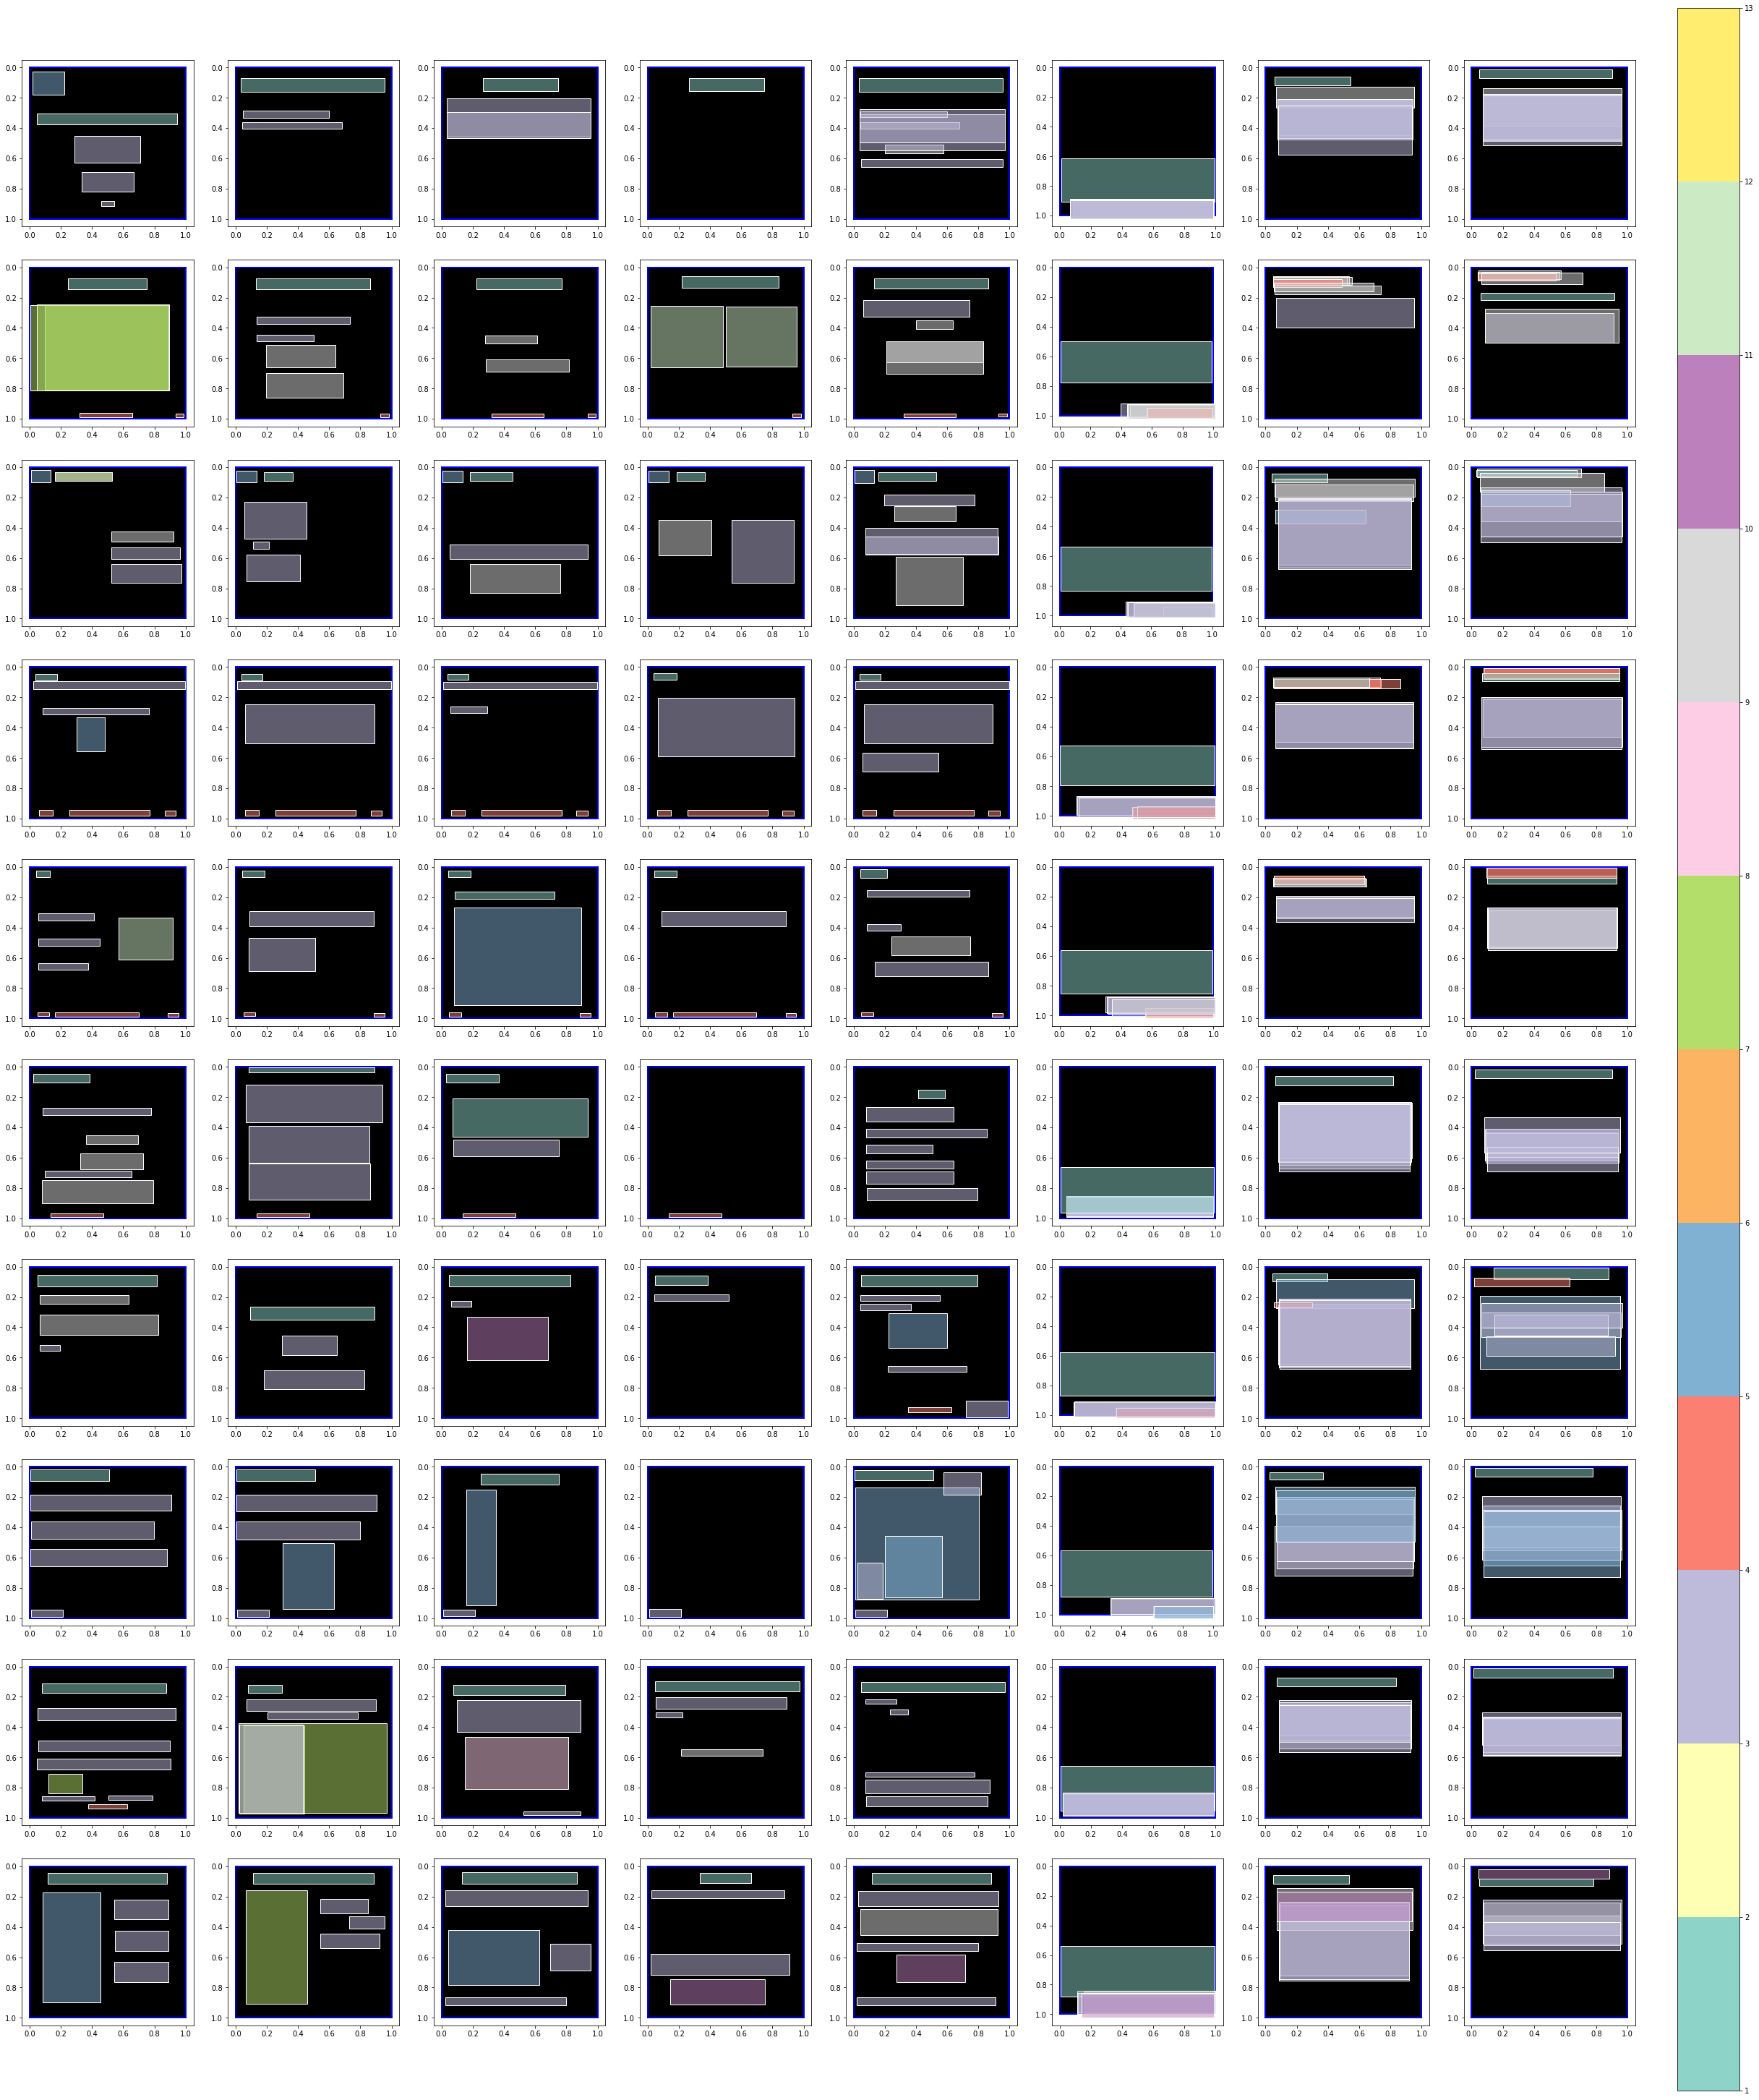

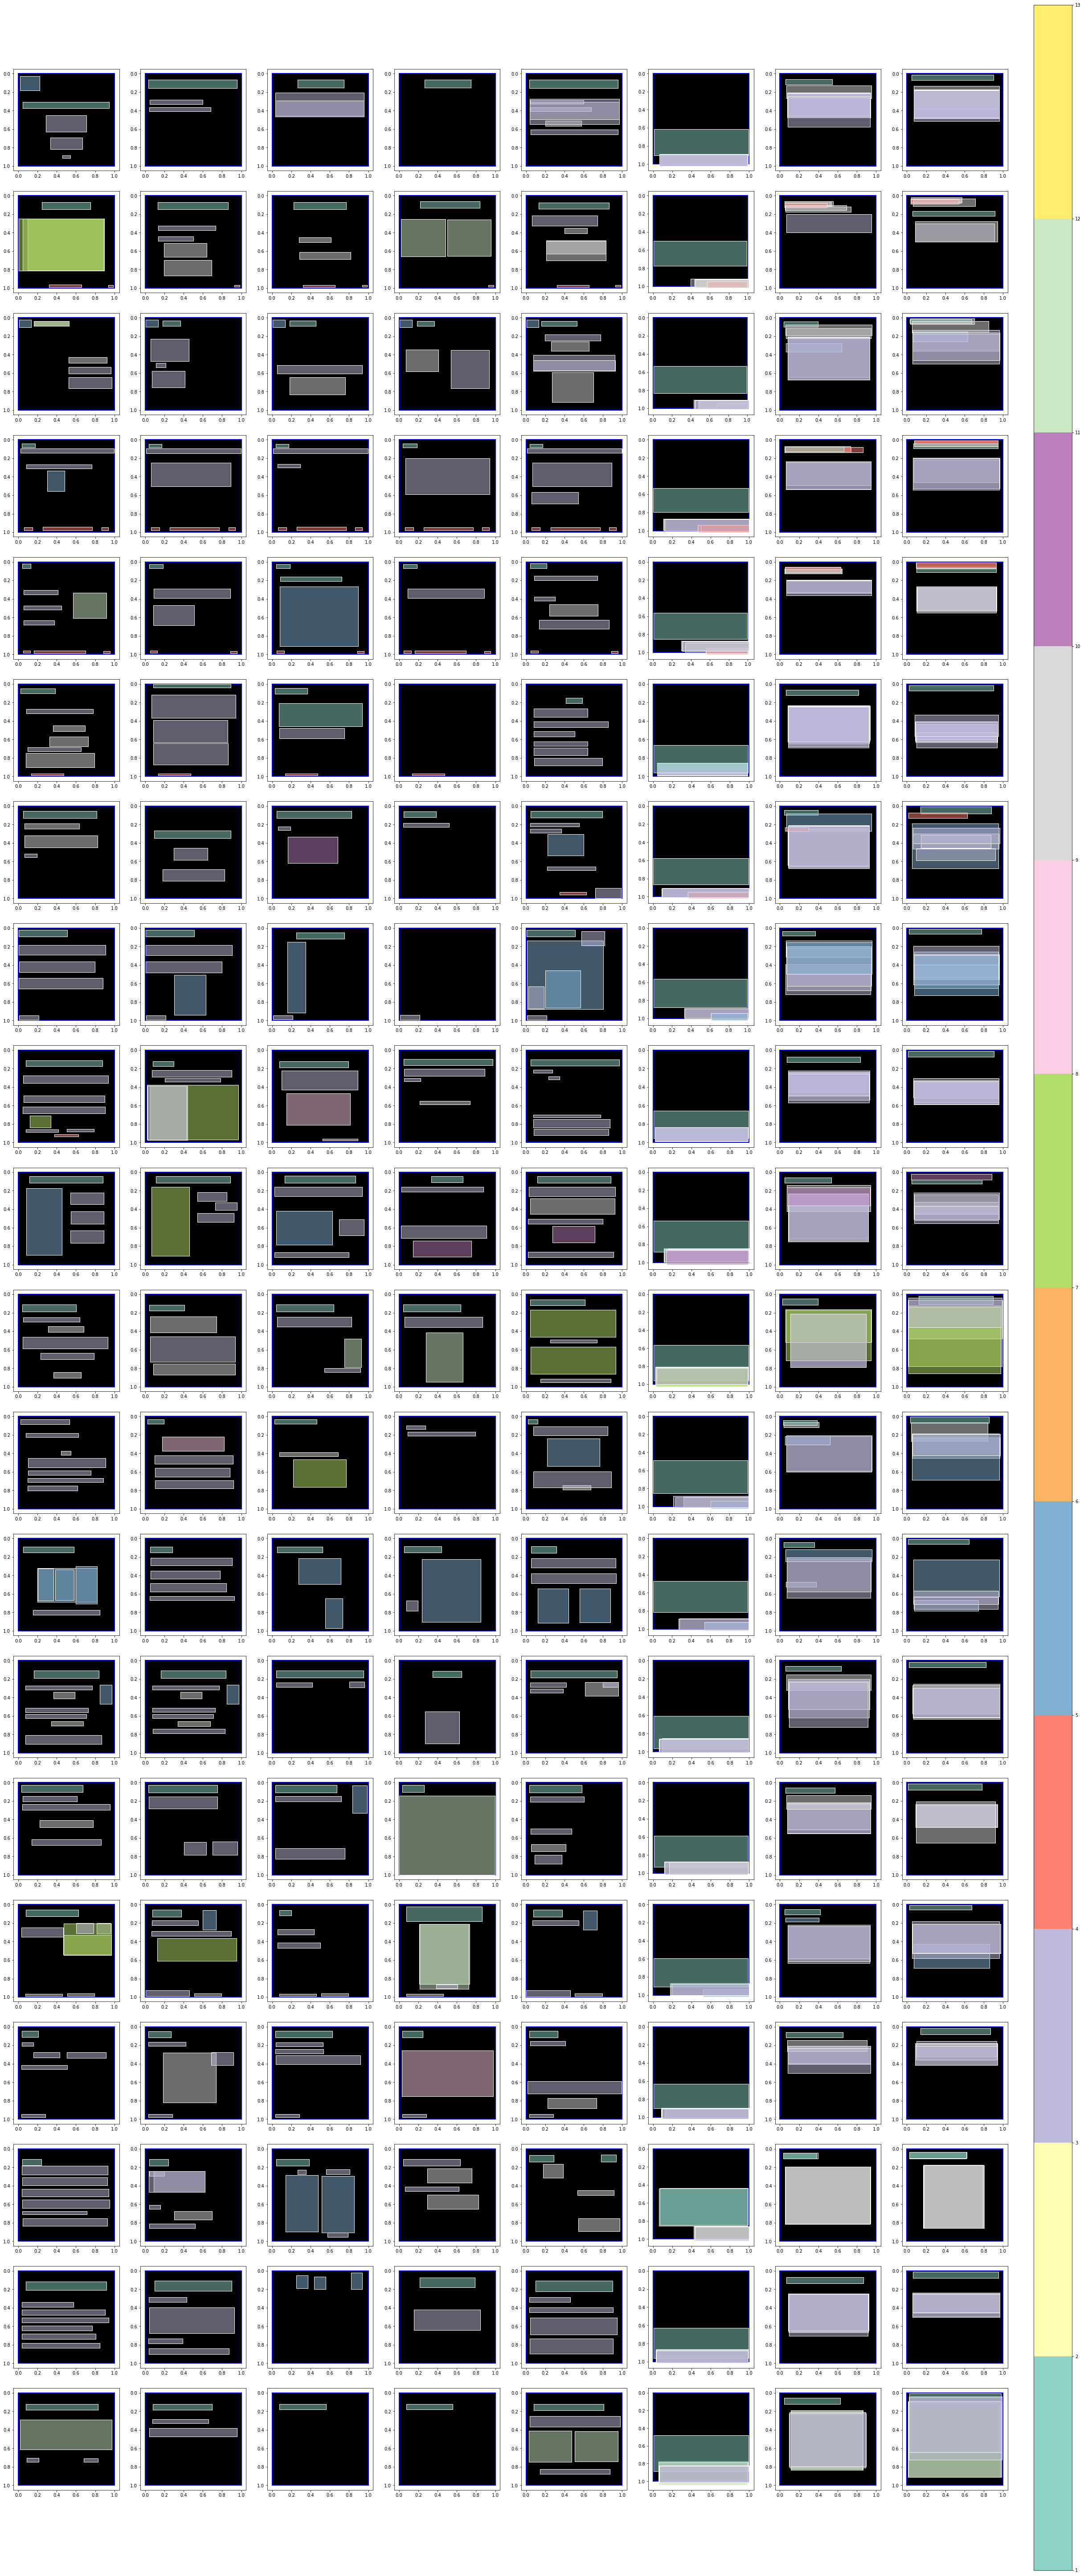

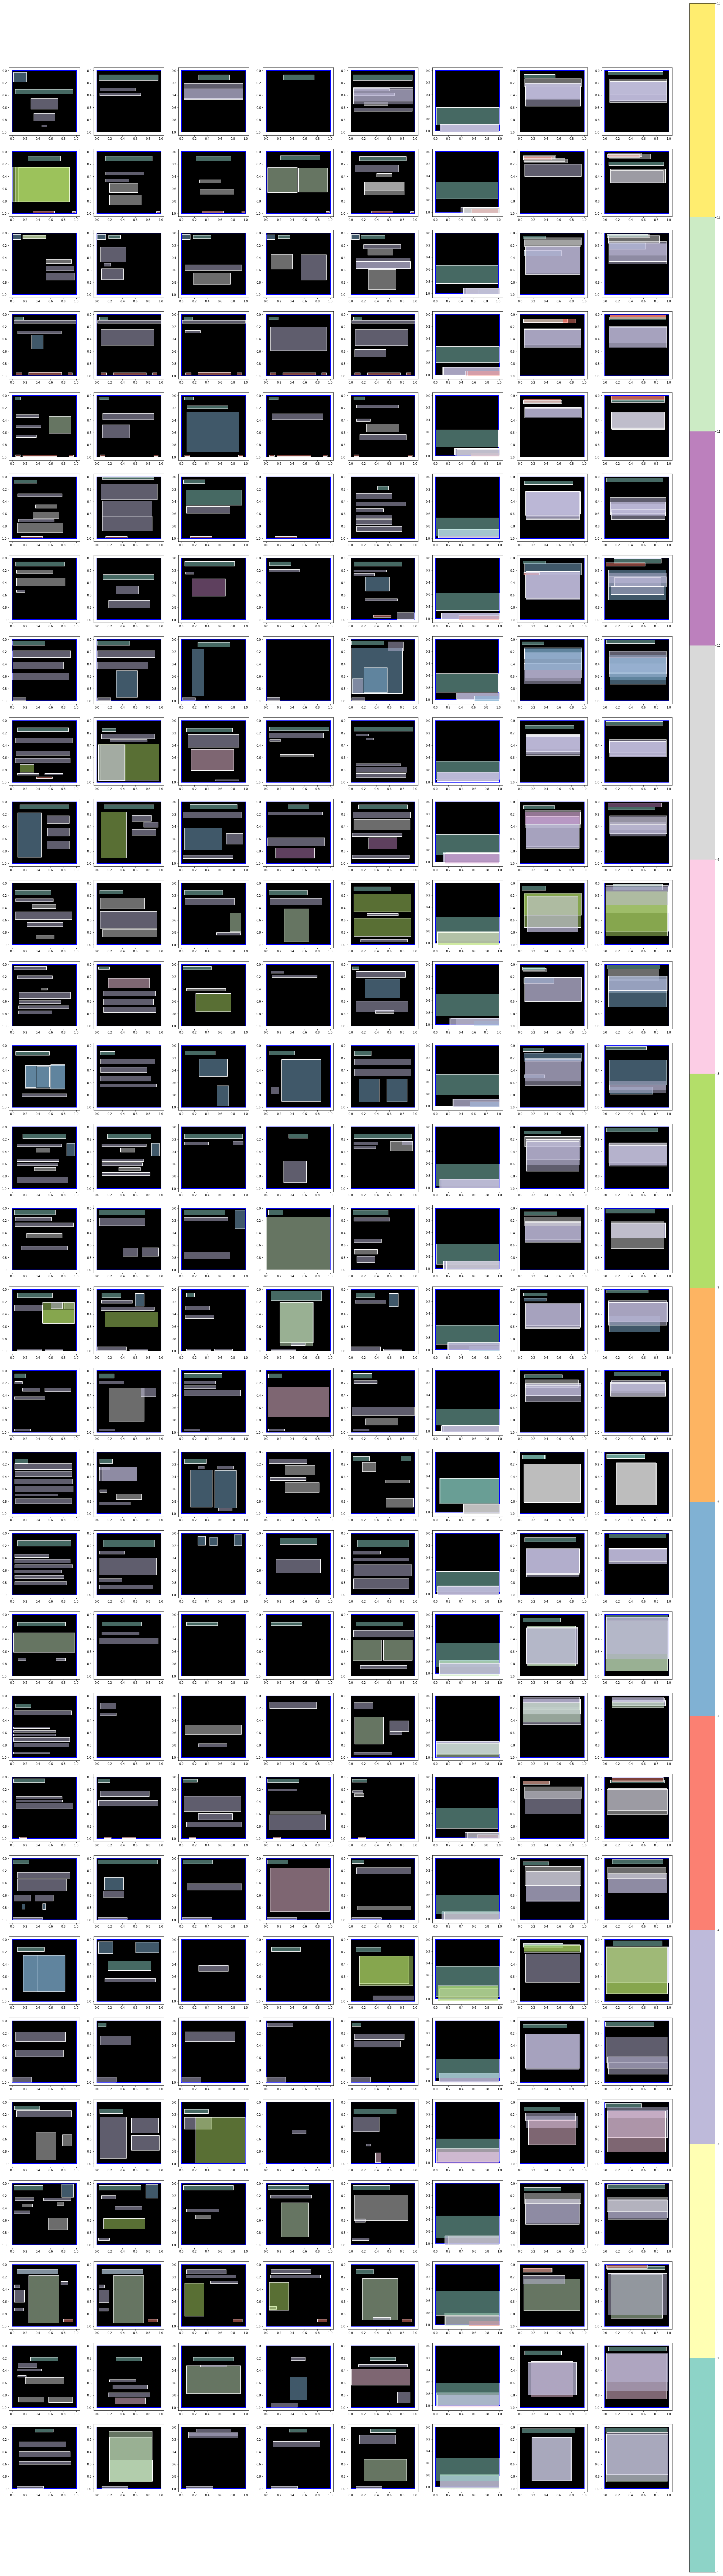

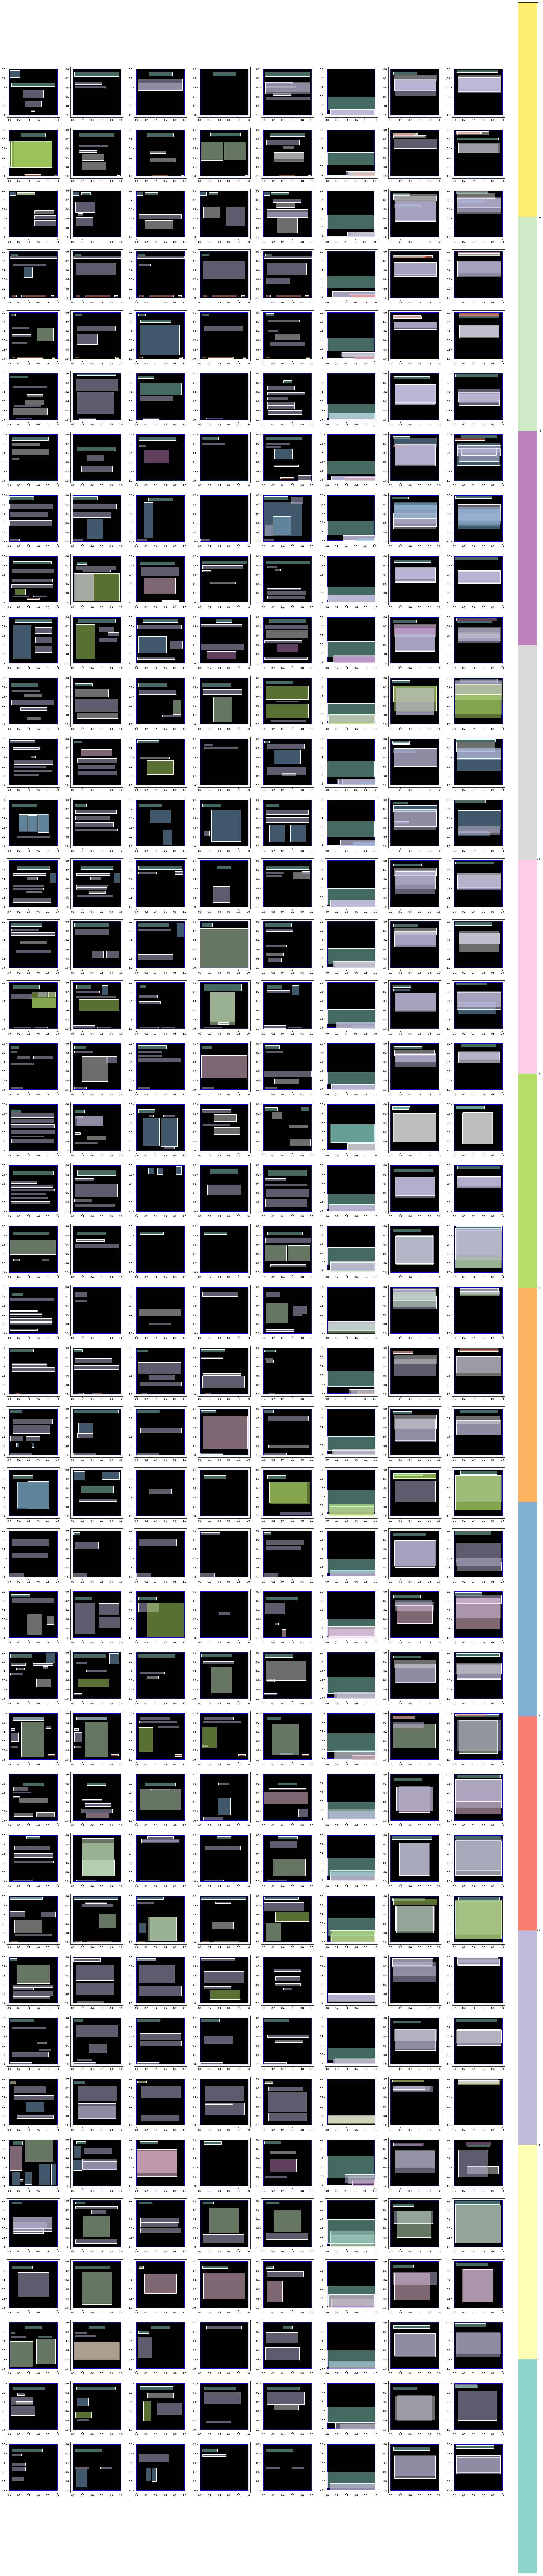

In [28]:

batch = SortByRefSlide(batch)
shape = batch["shape"].to(device)
slide_deck = batch["slide_deck"].to(device)
lengths_slide_deck = batch["lengths_slide_deck"].to(device)
ref_length = batch["length_ref_types"].to(device)
ref_types = batch["ref_types"].to(device).long()
ref_slide = batch["ref_slide"].to(device)

# deck encdoing
slide_deck = torch.transpose(slide_deck, 0, 1)
lengths_slide_deck = torch.transpose(lengths_slide_deck, 0, 1)
bboxes = slide_deck[:, :, :, :-1]
labels = slide_deck[:, :, :, -1].long()
padding_masks = ~(lengths_slide_deck[:, :, None] > torch.arange(labels.size(2)).to(device)[None, :])
models['encoder'].zero_grad()
deck_enc = models['encoder'](bboxes, labels, padding_masks)
deck_enc_rand = torch.rand(deck_enc.size()).to(device)
deck_enc_zero = torch.zeros(deck_enc.size()).to(device)

label = ref_types

padding_mask = ~(ref_length[:, None] > torch.arange(label.size(1)).to(device)[None, :])
bbox_real = ref_slide[:, :, :-1]

real_layouts_bbs = ref_slide[:,:,:-1]

z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (label.size(0), label.size(1), args.latent_size))))

optimizers["encoder"].zero_grad()
optimizers["discriminator"].zero_grad()

# Sample noise as generator input
fake_layouts_bbs = models['generator'](z, label, deck_enc, padding_mask).detach()
fake_layouts_bbs_rand = models['generator'](z, label, deck_enc_rand, padding_mask).detach()
fake_layouts_bbs_zero = models['generator'](z, label, deck_enc_zero, padding_mask).detach()

list_bboxes = []
list_labels = []
for n in range(40):
    for i in range(4):
        list_bboxes.append(bboxes[i, n, :, :])
        list_labels.append(labels[i, n, :])

    list_bboxes.append(real_layouts_bbs[n])
    list_labels.append(ref_types[n])

    list_bboxes.append(fake_layouts_bbs[n])
    list_labels.append(ref_types[n])

    list_bboxes.append(fake_layouts_bbs_rand[n])
    list_labels.append(ref_types[n])

    list_bboxes.append(fake_layouts_bbs_zero[n])
    list_labels.append(ref_types[n])

draw_all_bbs(shape[n], list_bboxes, list_labels, 8, False)


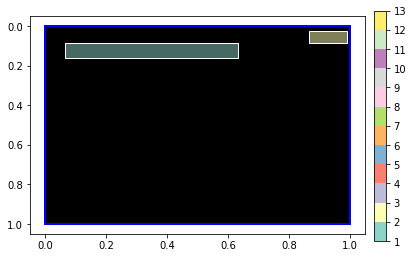

In [10]:
for i in range(1):
    z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (label.size(0), label.size(1), args.latent_size))))

    optimizers["encoder"].zero_grad()
    optimizers["discriminator"].zero_grad()

    # Sample noise as generator input
    fake_layouts_bbs = models['generator'](z[n:n+1], label[n:n+1], deck_enc[n:n+1], padding_mask[n:n+1]).detach()
    draw_bbs(shape[n], fake_layouts_bbs[0], ref_types[n], False)